In [1]:
using Crystalline, MPBUtils, JLD2, LinearAlgebra, StaticArrays, SymmetryBases, PyPlot, DelimitedFiles, PrettyTables, 
Brillouin, PyCall, Statistics
using Crystalline: symvec2string
include("./symeigs/corner_charges.jl")
include("./symeigs/wyckoffs_dict.jl");
include("plotting_utilities.jl")
brs = bandreps(10, 2); # For decomposing later on 
brs_labs = ["(" * br.wyckpos * "|"  * prod(string.(collect(br.label)[1:end-2])) * ")" for br in brs];

In [2]:
# Find where we have cumulatively fragile bands
symeigs_dir = "./symeigs/"
cum_fragile_count = Dict{Tuple{Integer, Integer, String}, Vector{Float64}}()
for sg in [2, 6, 9:17...]
    loaded_data = load(symeigs_dir*"sg$sg-data.jld2")
    merge!(cum_fragile_count, Dict(x => y[1:3] ./ 100 for (x, y) in loaded_data["cum_fragile_count"]))
end

In [3]:
# Filter out all the ones that don't have some cumulatively fragile bands
filter(x -> !iszero(x[2]), cum_fragile_count)

Dict{Tuple{Integer, Integer, String}, Vector{Float64}} with 4 entries:
  (10, 4, "te") => [0.0, 0.12, 0.0]
  (10, 5, "te") => [0.0, 0.09, 0.0]
  (10, 2, "te") => [0.0, 0.08, 0.0]
  (10, 3, "te") => [0.0, 0.14, 0.0]

In [4]:
# We see that only space group 10 and only TE polarization yields cumulatively fragile bands. So we inspect 
# spacegroup 10 and te polarization in more detail below 

id_eps = 1
file = "./symeigs/output/sg10/eps$(id_eps)/te/sg10-epsid$(id_eps)-res64-te.jld2"
loaded_data_eps1 = load(file)

id_eps = 2
file = "./symeigs/output/sg10/eps$(id_eps)/te/sg10-epsid$(id_eps)-res64-te.jld2"
loaded_data_eps2 = load(file)

id_eps = 3
file = "./symeigs/output/sg10/eps$(id_eps)/te/sg10-epsid$(id_eps)-res64-te.jld2"
loaded_data_eps3 = load(file)

id_eps = 4
file = "./symeigs/output/sg10/eps$(id_eps)/te/sg10-epsid$(id_eps)-res64-te.jld2"
loaded_data_eps4 = load(file);

id_eps = 5
file = "./symeigs/output/sg10/eps$(id_eps)/te/sg10-epsid$(id_eps)-res64-te.jld2"
loaded_data_eps5 = load(file);

In [5]:
all_cumsummariesv = vcat([x["cumsummariesv"] for x in [loaded_data_eps1, loaded_data_eps2, loaded_data_eps3,
                loaded_data_eps4, loaded_data_eps5]]...);
@assert length(all_cumsummariesv) == 10000*5

In [6]:
brs_decomps = Vector{String}()
ids_mod_eps = Vector{Int64}() # Since the only difference between different contrasts is the epsin value, such cases give us the 
#same fourier lattice. Therefore, we look at ids mod the number of lattices per contrast 
ids = Vector{Int64}()
for (idx, cumsummaries) in enumerate(all_cumsummariesv)
    for cumsummary in cumsummaries
        cumsummary.topology == FRAGILE || continue # If not fragile, don't bother
        brs_decomp = decompose(cumsummary.n, brs)
        brs_decomp = Crystalline.symvec2string(brs_decomp, brs_labs)
        push!(brs_decomps, brs_decomp)
        #push!(ids_mod_eps, idx - 10000*floor(idx/10000))
        push!(ids_mod_eps, mod(idx, 10000))
        push!(ids, idx)
    end
end

In [7]:
println("Lattices with cummulative corner charge: $(unique(ids_mod_eps))")

Lattices with cummulative corner charge: [772, 2141, 2488, 7021, 8064, 8159, 8545, 9229, 132, 1152, 1548, 3742, 5243, 7163, 9939, 328, 404, 733, 4025, 4382, 5780, 7205, 526, 811, 1322, 2221, 2798, 5726, 8660]


In [8]:
# A dictionary that shows which values of epsilon give fragile bands for a particular id mod 10000
fragile_eps = Dict{Int, Vector{Int}}()
for id in unique(ids_mod_eps)
    eps_idxs = findall(i -> any(x -> id == x - 10000*(i-1), ids), [1, 2, 3, 4, 5])
    push!(fragile_eps, id => eps_idxs)
end

In [9]:
# Check that length is correct
sum(length.([val for (key, val) in fragile_eps]))

43

In [20]:
# print all the ids that give cumulatively fragile bands for each dielectric contrast
for id_eps in 2:5
    println("Dielectric contrast index $id_eps has cumulatively fragile bands for lattices indexed by: \n", [10000*(id_eps - 1) + x[1] for x in filter(x-> id_eps ∈ x[2], fragile_eps)])
    println("\n")
end

Dielectric contrast index 2 has cumulatively fragile bands for lattices indexed by: 
[18064, 19229, 10772, 18159, 12141, 18545, 12488, 17021]


Dielectric contrast index 3 has cumulatively fragile bands for lattices indexed by: 
[28159, 27163, 22488, 21548, 27021, 25243, 21152, 23742, 28064, 29229, 20772, 29939, 28545, 20132]


Dielectric contrast index 4 has cumulatively fragile bands for lattices indexed by: 
[30328, 37163, 35780, 34025, 30404, 31152, 37205, 39229, 34382, 39939, 30733, 30132]


Dielectric contrast index 5 has cumulatively fragile bands for lattices indexed by: 
[40404, 48660, 44382, 45726, 41322, 40811, 40526, 42798, 42221]




In [37]:
# Find all possible epsilon values that give fragile bands
unique([val for (_, val) in fragile_eps])

8-element Vector{Vector{Int64}}:
 [4]
 [5]
 [2, 3]
 [3, 4]
 [3]
 [4, 5]
 [2]
 [2, 3, 4]

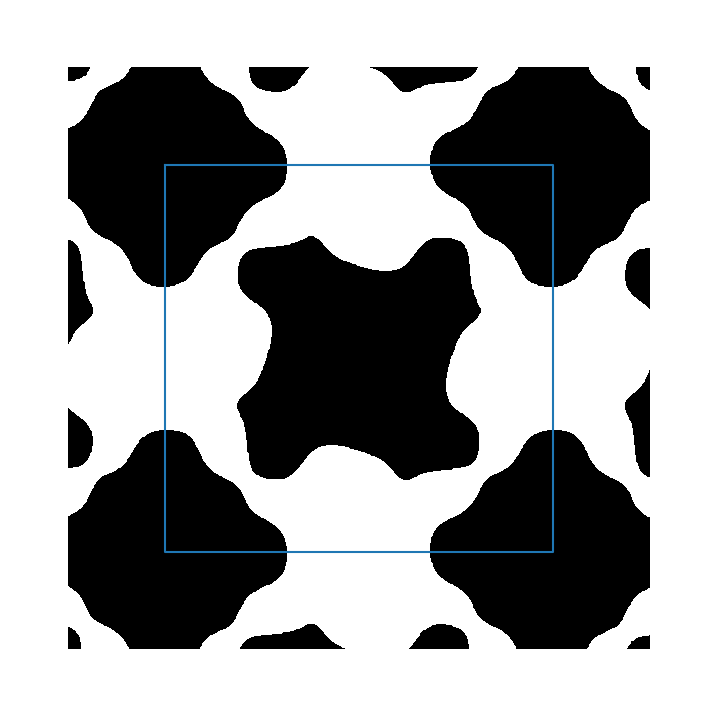

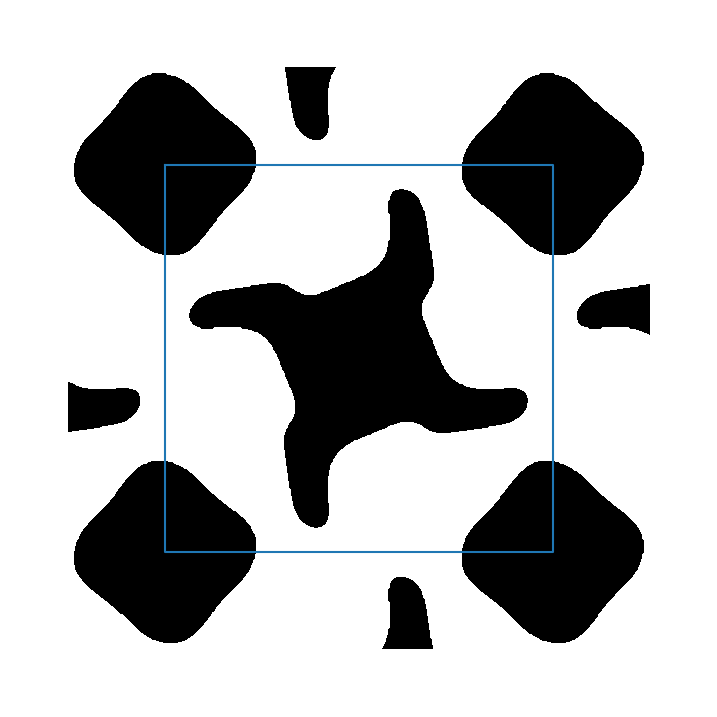

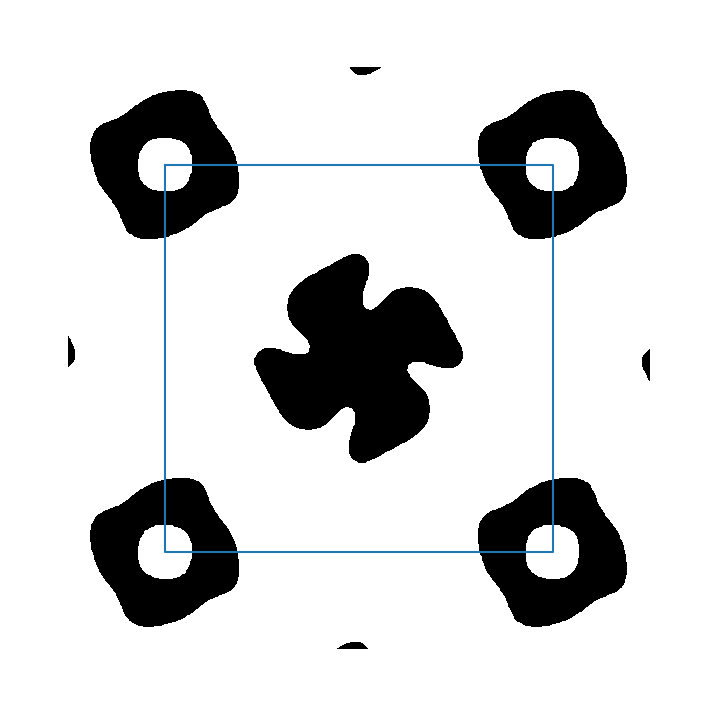

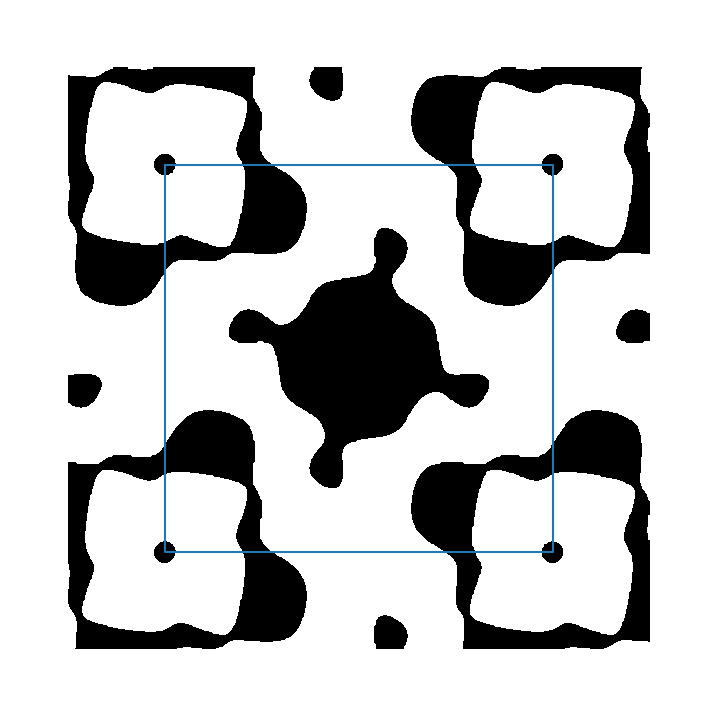

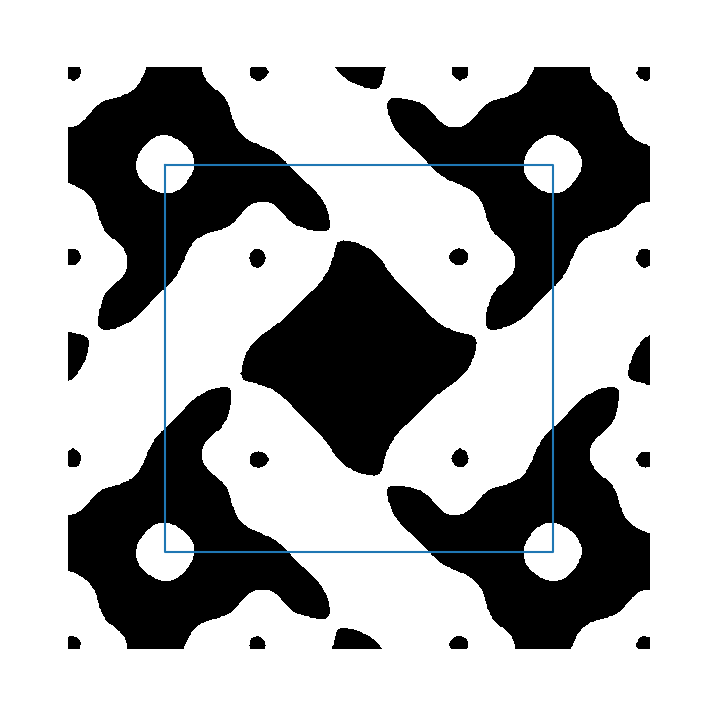

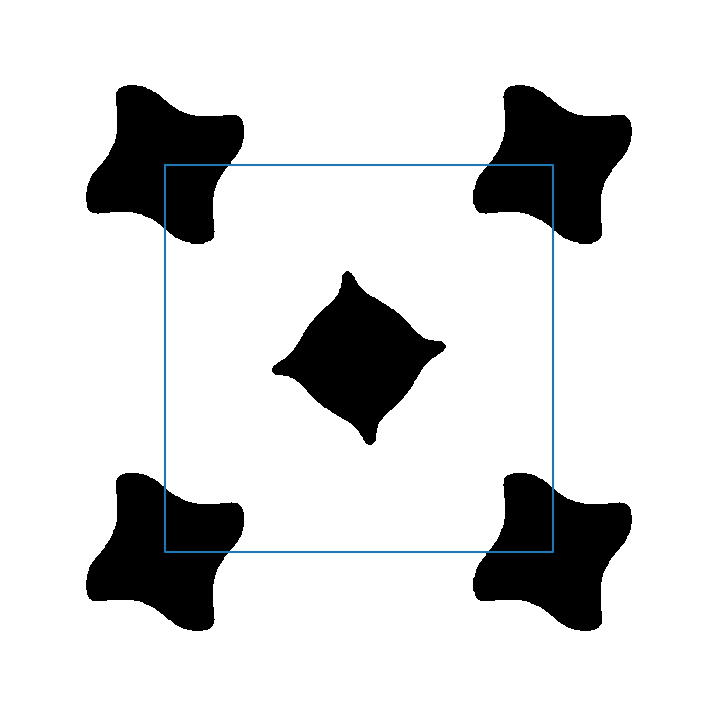

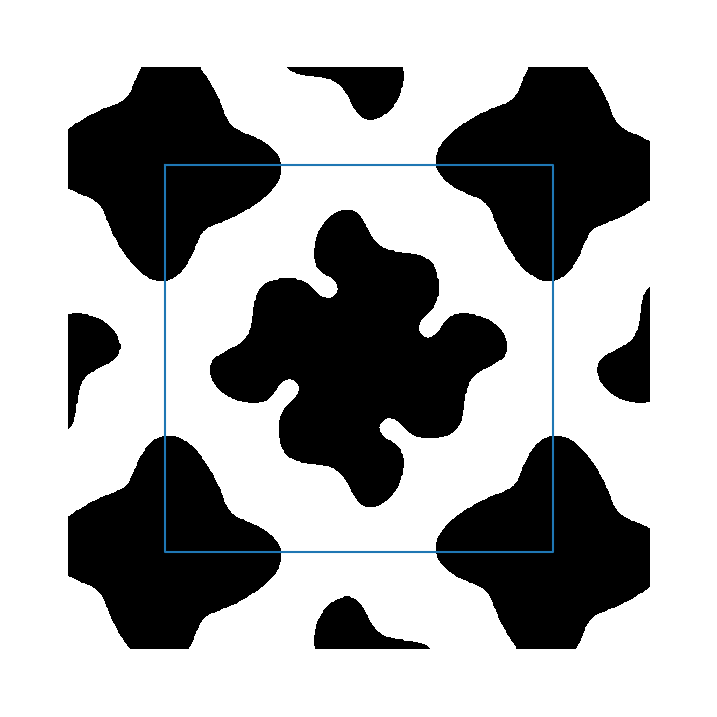

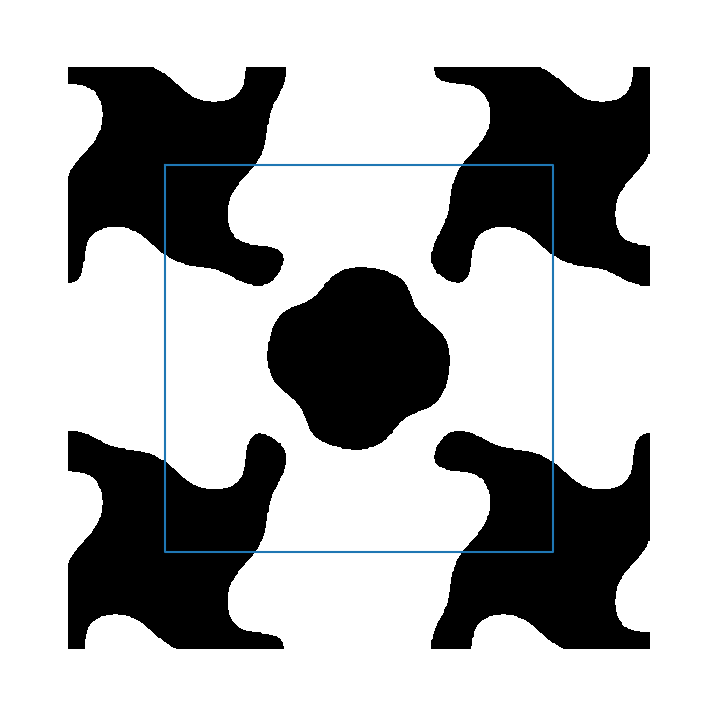

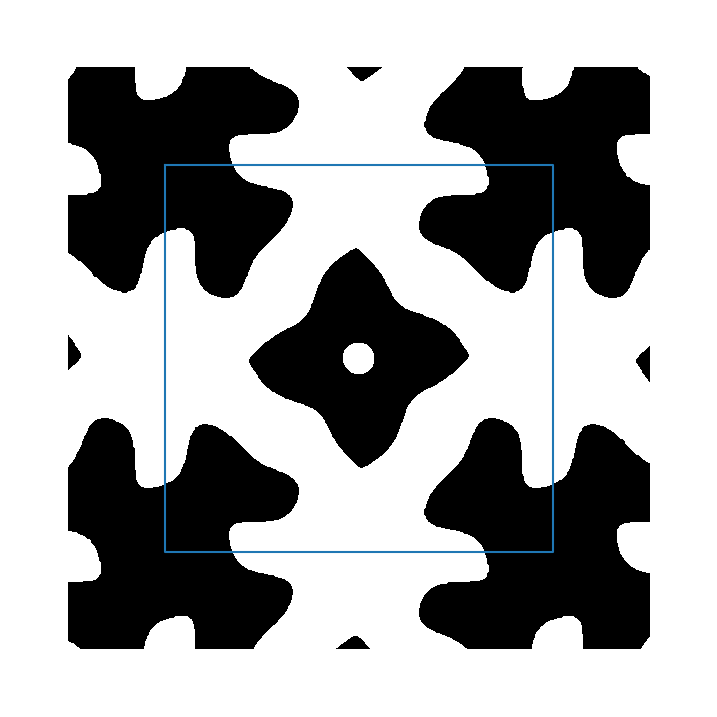

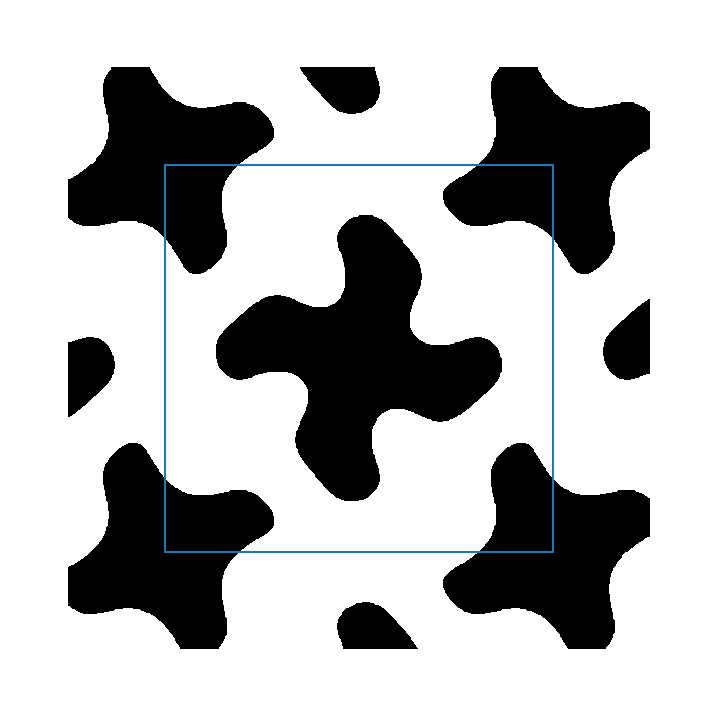

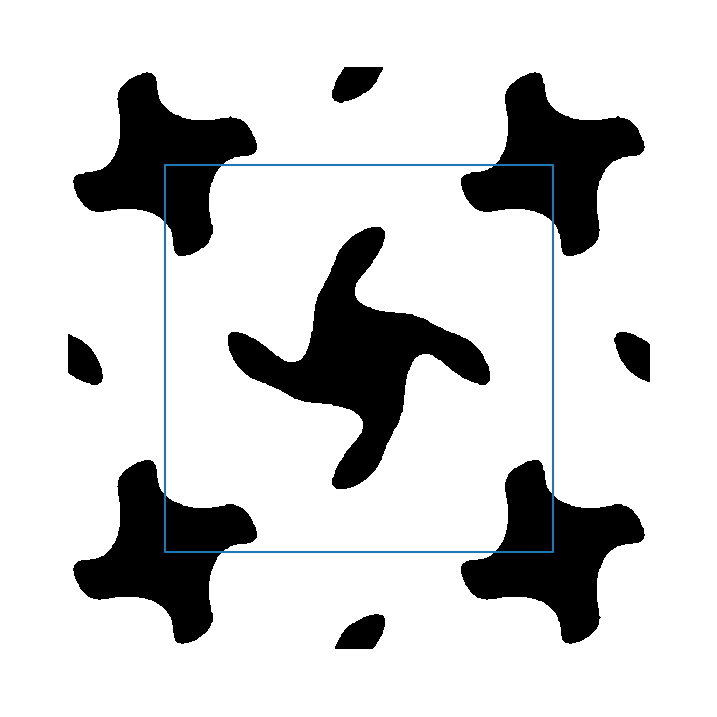

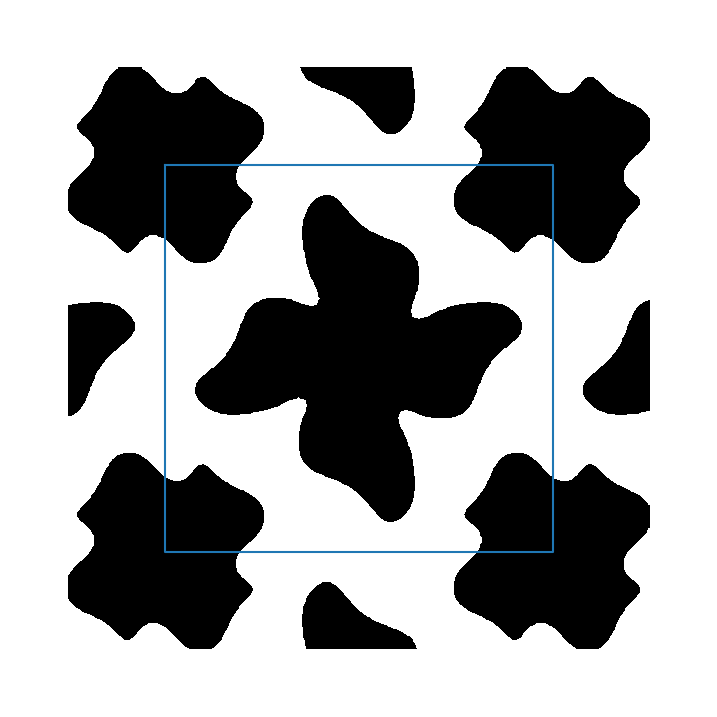

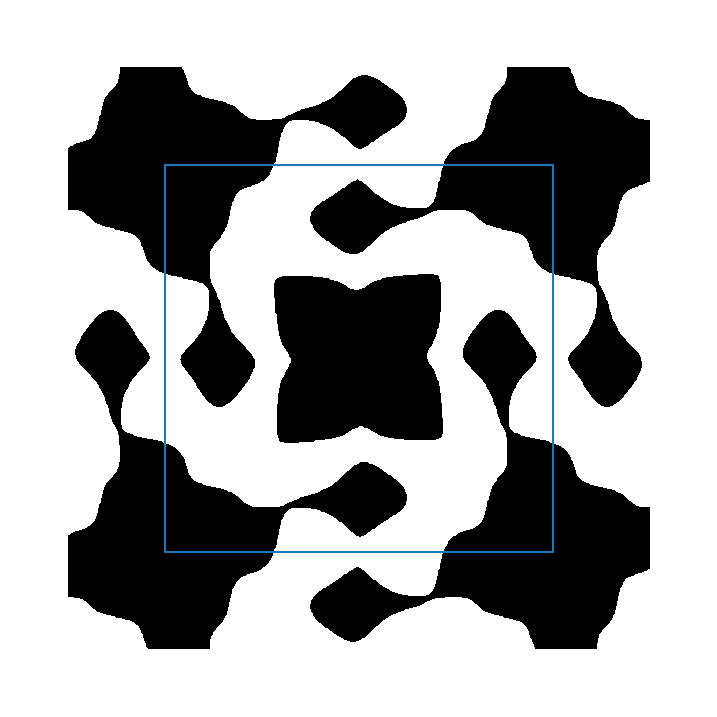

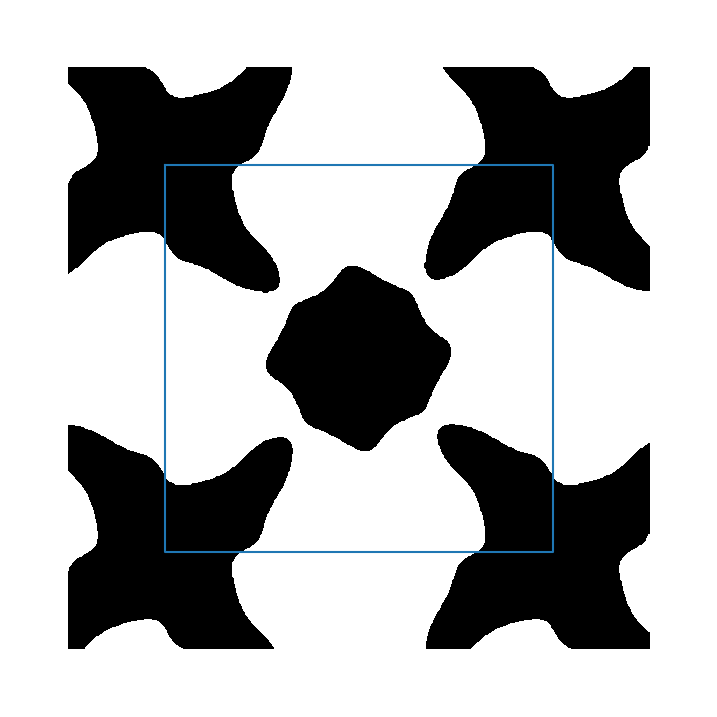

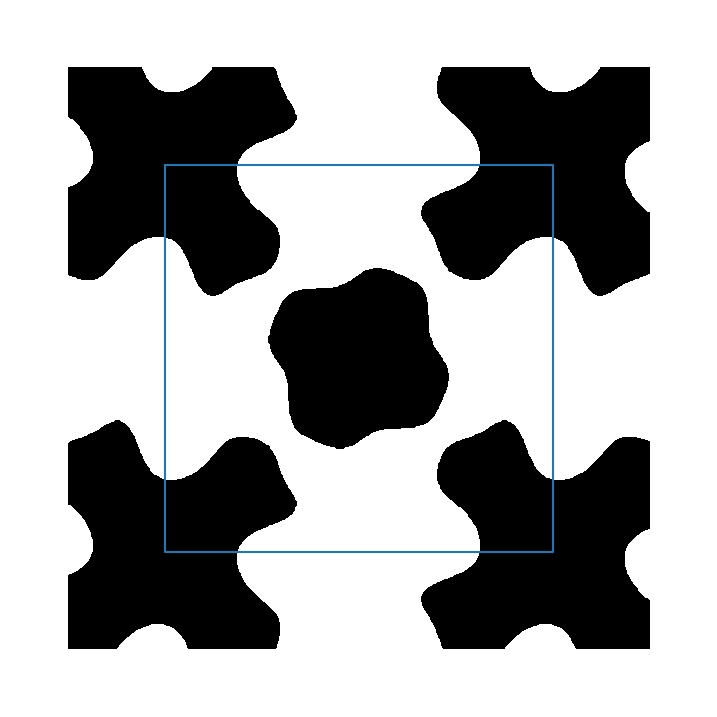

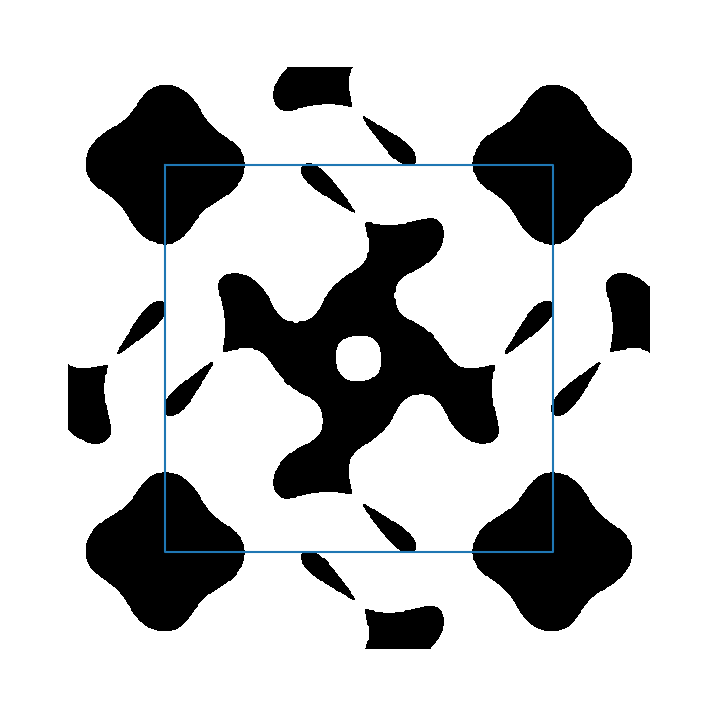

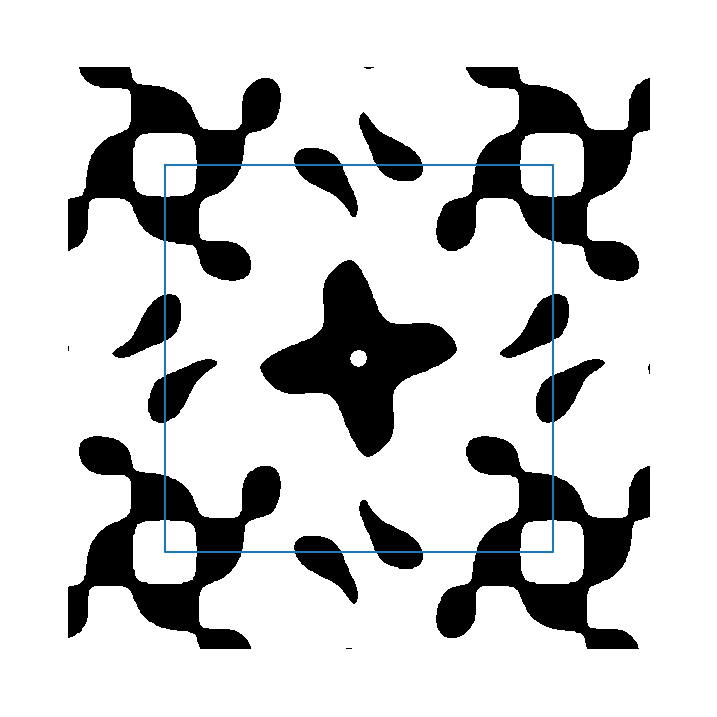

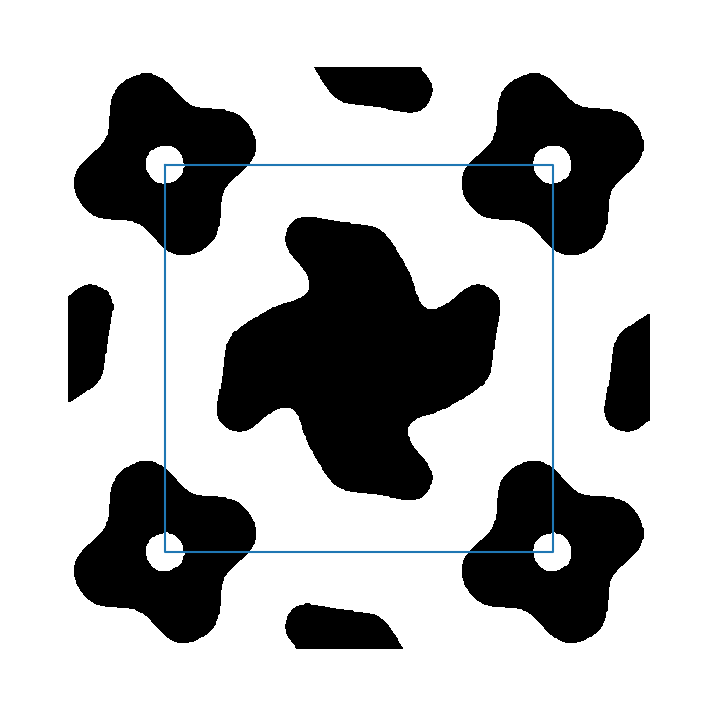

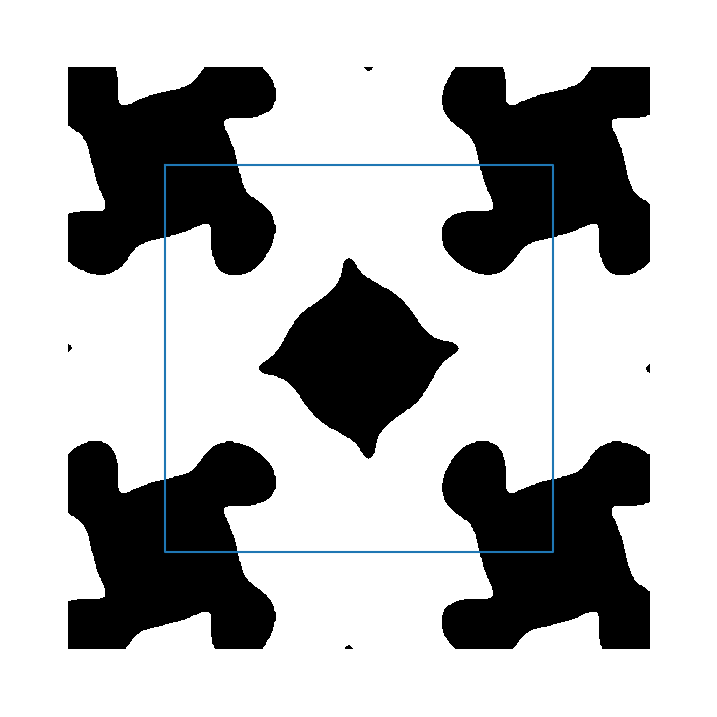

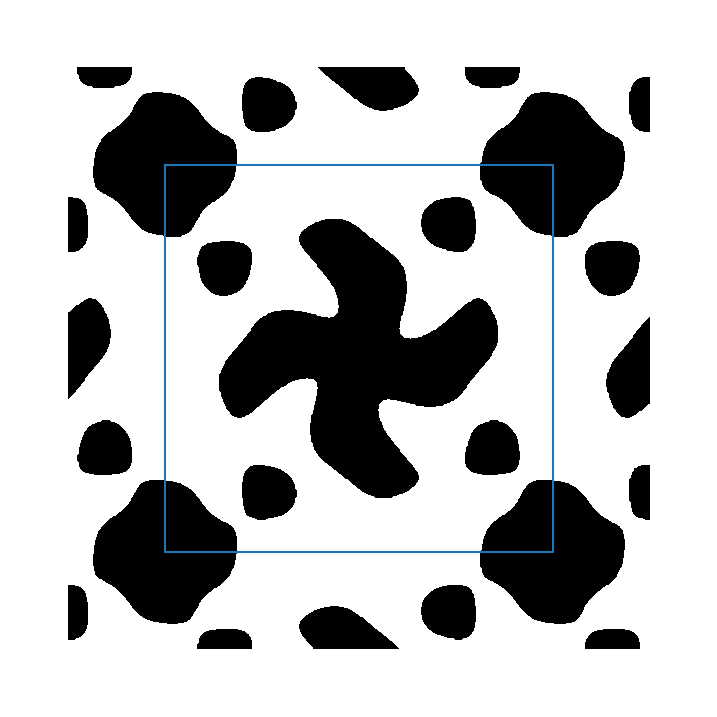

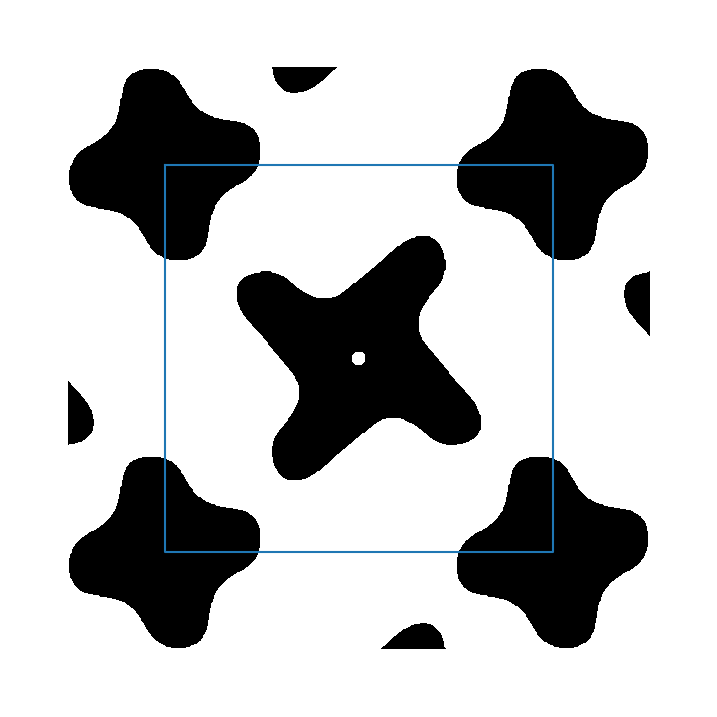

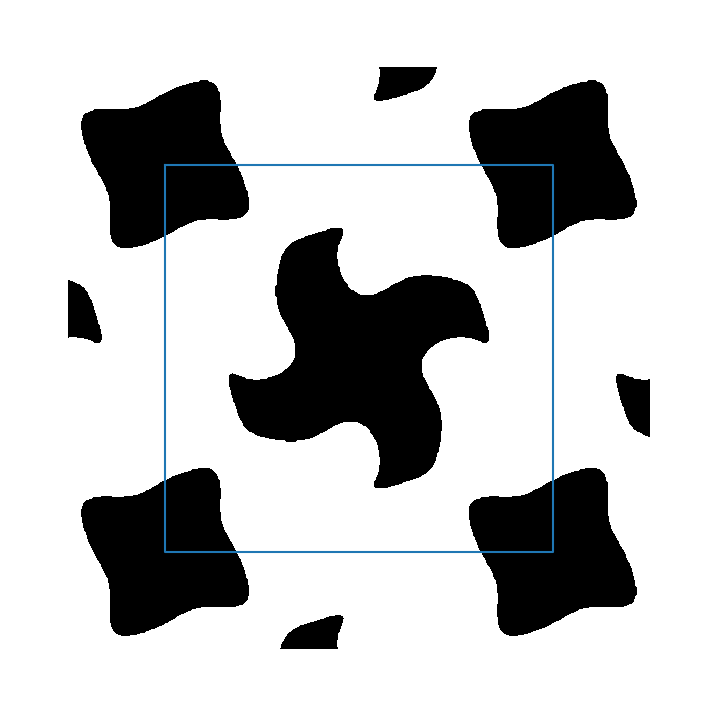

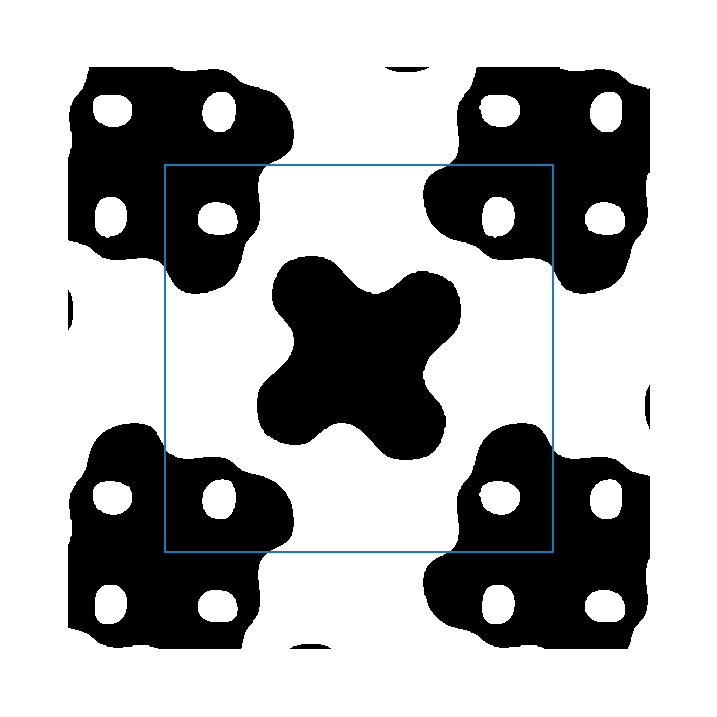

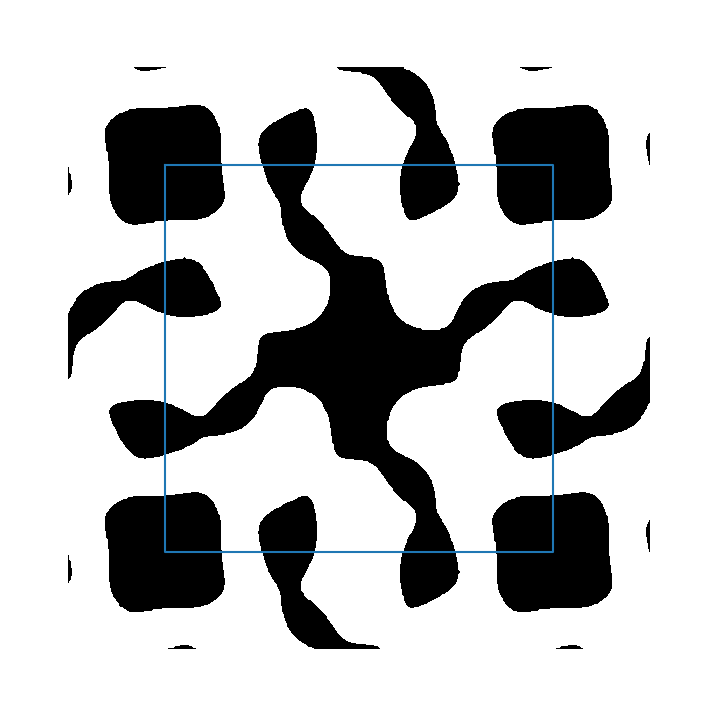

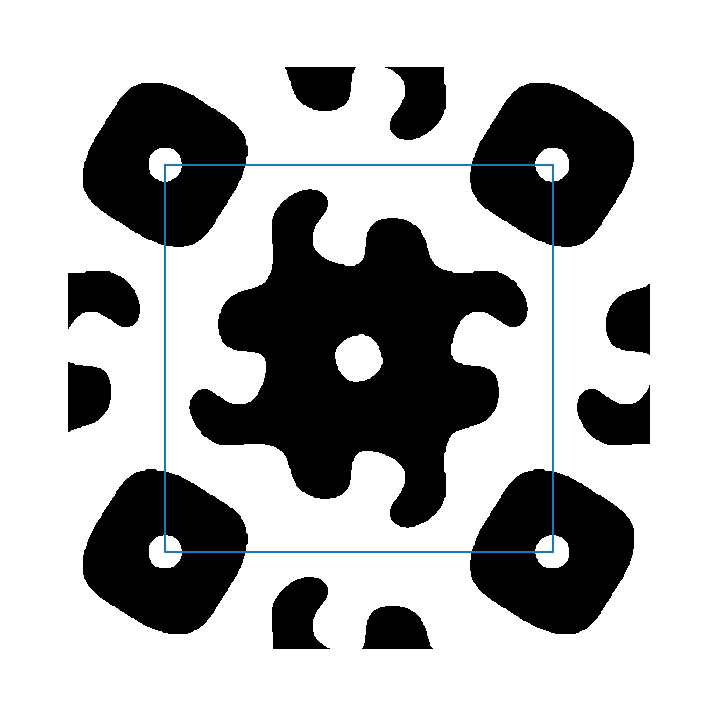

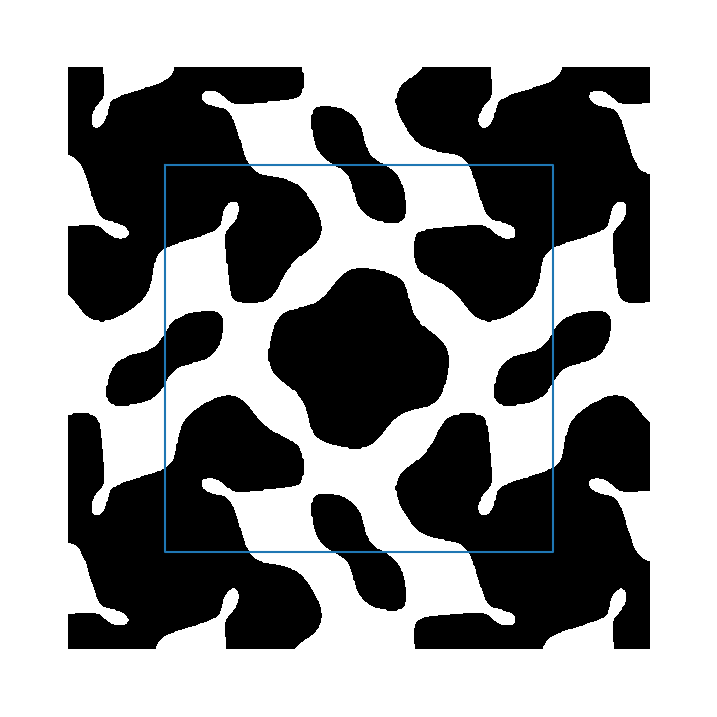

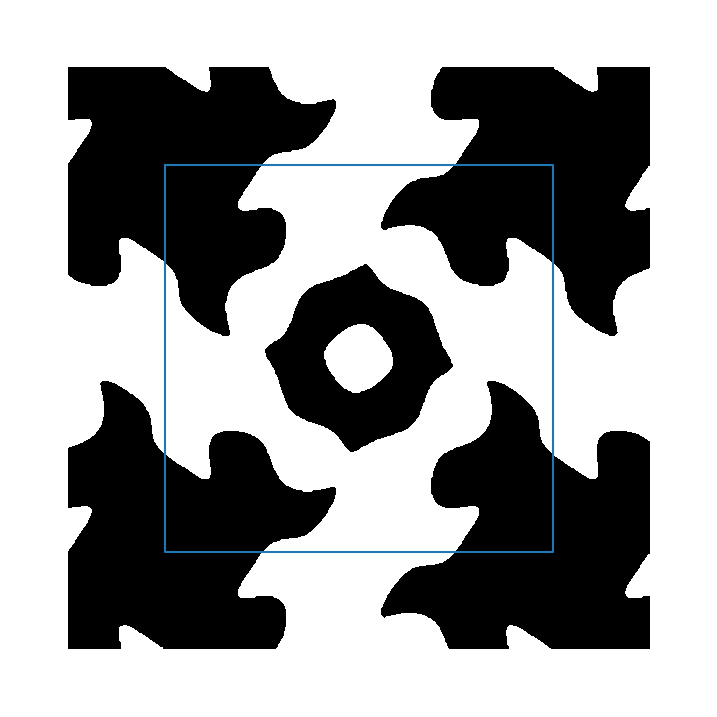

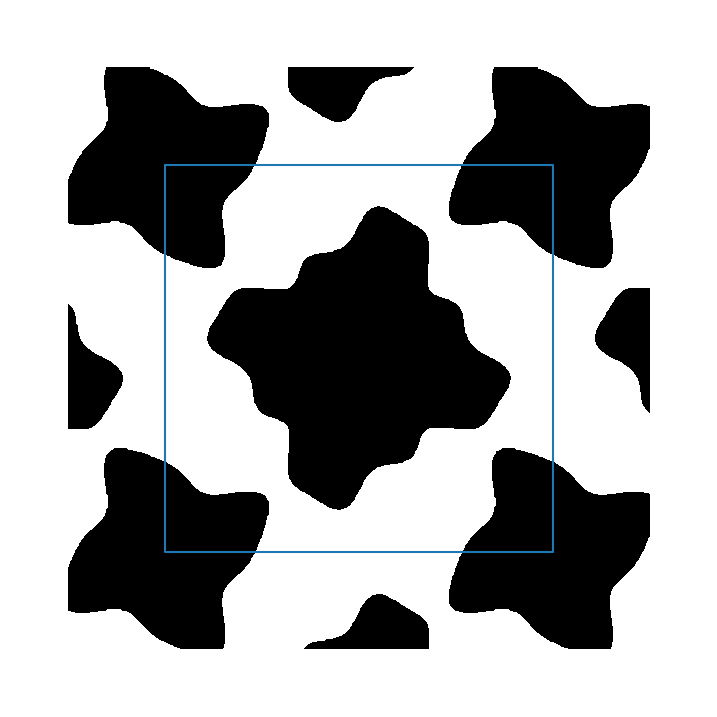

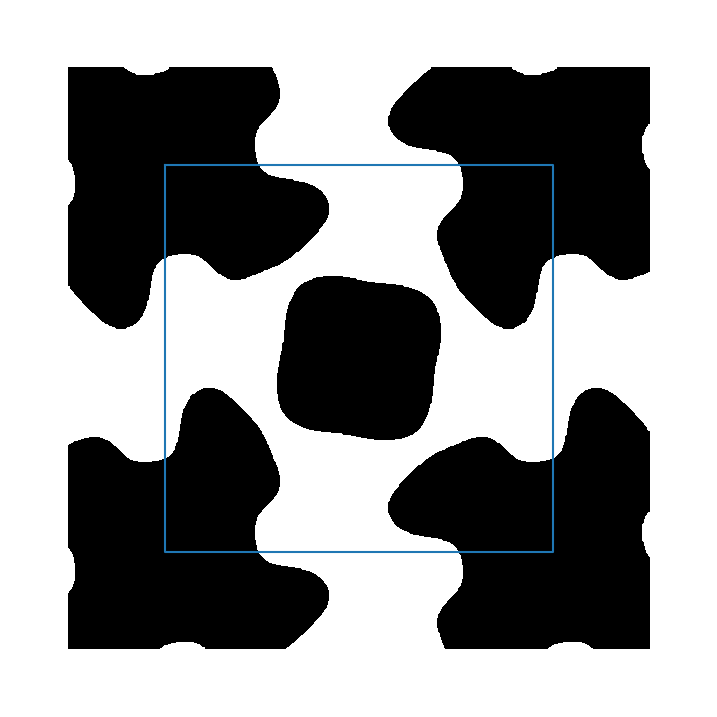

In [67]:
boundaries = 0.9
sg = 10
dir = "./Sg10_Cumulatively_Fragile_Lattices/"
for (i, id) in enumerate(unique(ids_mod_eps))
    fig = figure(figsize=(9, 12))
    calcname = "./symeigs/input/dim2-sg$(sg)-$id-res64-te.sh"
    Rs, flat, isoval, _ = lattice_from_mpbparams(calcname)
    wigner_cell = wignerseitz(Rs)
    wigner_plot(flat, Rs, wigner_cell; isoval=isoval, fig=fig, ax=gca(), N=500)
    xlim(-boundaries, boundaries)
    ylim(-boundaries, boundaries)
   # savefig(dir*"Fragile-$id.pdf")
end

In [22]:
# Find all unique decompositions of fragile bands
println("The unique elementary band representations for the fragile bands: ", unique(brs_decomps))
# Note that they are related by fractional (1/2, 1/2) lattice translations 

The unique elementary band representations for the fragile bands: ["[(2c|A)+(1b|A)+(1a|A)-(1a|B)]", "[(2c|A)+(1b|A)-(1b|B)+(1a|A)]"]


In [13]:
# Figure S3

In [27]:
band3 = zeros(501*501)
band4 = zeros(501*501)
all_bands = zeros(501*501, 11)
for idx in 1:200
    #println(idx); flush(stdout)
    top_band = 3
    dispersion = readdlm("symeigs/cum_fragile/nodal_points/output/dim2-sg10-27163-res32-te-$idx-dispersion.out", ',', Float64)
    dispersion = sort(dispersion[:, 6:end], dims = 2)
    lower_dispersion = dispersion[:, top_band]
    upper_dispersion = dispersion[:, top_band+1]
    gap = minimum(upper_dispersion - lower_dispersion)
    gap < 0 && (println("Negative Gap at idx: $idx"); flush(stdout); println(argmin(upper_dispersion - lower_dispersion)))
    band3[idx:200:end] =  lower_dispersion 
    band4[idx:200:end] =  upper_dispersion 
end


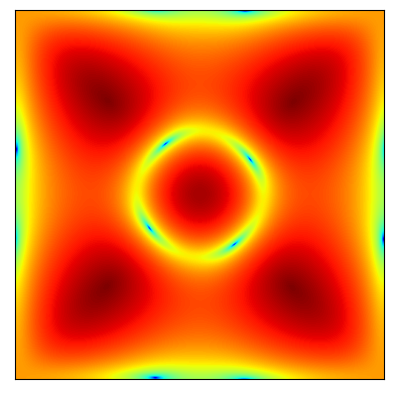

(Any[], Any[])

In [28]:
imshow(transpose(log.(reshape(band4 - band3 , (501, 501)))), cmap="jet", origin="lower")
xticks(Float64[])
yticks(Float64[])

In [35]:
id = 27163
bands192 = readdlm("./symeigs/cum_fragile/dispersions/output/dim2-sg10-$id-res192-te-dispersion.out", ',')[:, 6:end];

In [56]:
# Find indices of high symmetry k points
kpoints = readdlm("./symeigs/cum_fragile/dispersions/output/dim2-sg10-$id-res192-te-dispersion.out", ',')[:, 2:3]
Γ_idxs = findall(k -> isapprox(k, zeros(2)), [row for row in eachrow(kpoints)])
X_idxs = findall(k -> isapprox(k, [0, 1/2]), [row for row in eachrow(kpoints)])
M_idxs = findall(k -> isapprox(k,  [1/2, 1/2]), [row for row in eachrow(kpoints)])

println("Γ (0, 0) indices: ", Γ_idxs)
println("M (1/2, 1/2) indices: ", M_idxs)
println("X (0, 1/2) indices: ", X_idxs )

Γ (0, 0) indices: [1, 11999]
M (1/2, 1/2) indices: [4971]
X (0, 1/2) indices: [8485]


In [52]:
lgirreps(10, 2)["X"]

LGIrrep{2}: ⋕10 (p4) at X = [0, 1/2]
X₁ ─┬─────────────────────────────────────────────
    ├─ 1: ────────────────────────────────── (x,y)
    │     1.0
    │
    ├─ 2: ──────────────────────────────── (-x,-y)
    │     1.0
    └─────────────────────────────────────────────
X₂ ─┬─────────────────────────────────────────────
    ├─ 1: ────────────────────────────────── (x,y)
    │     1.0
    │
    ├─ 2: ──────────────────────────────── (-x,-y)
    │     -1.0
    └─────────────────────────────────────────────

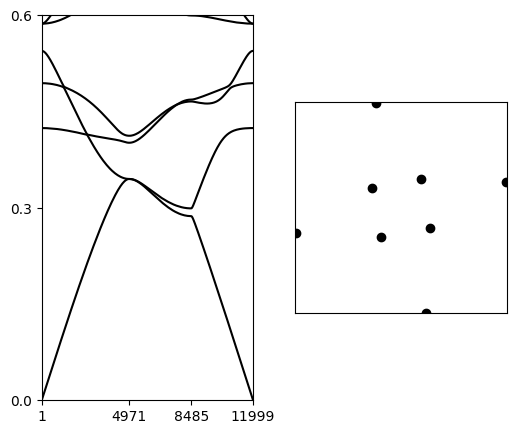

(Any[], Any[])

In [36]:
cum_fragile_dispersion_dir = "./Cumulatively_Fragile_Dispersion/"
figure(figsize=(6, 5))
subplot(1, 2, 1)
plot(1:11999, bands192, color="black")
#vlines(1144, 0, 0.8)
#vlines(11057, 0, 0.8)
xticks([1, 4971, 8485, 11999])
ylim(0, 0.6)
xlim(1, 11999)
yticks([0, 0.3, 0.6])
subplot(1, 2, 2)
scatter(-0.498, -0.12, color="black")
scatter(0.498, 0.12, color="black")
scatter(0.12, -0.498, color="black")
scatter(-0.12, 0.498, color="black")

scatter(0.0934, 0.136, color="black")
scatter(-0.0934, -0.136, color="black")
scatter(-0.136, 0.0934, color="black")
scatter(0.136, -0.0934, color="black")

xlim(-0.5, 0.5)
ylim(-0.5, 0.5)
gca().set_aspect("equal", adjustable="box")
xticks([])
yticks([])
#savefig(cum_fragile_dispersion_dir*"Fragile_Band_Nodal_Point.pdf")

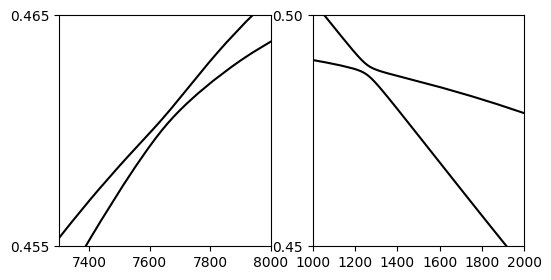

(PyObject[PyObject <matplotlib.axis.YTick object at 0x7f2fba375670>, PyObject <matplotlib.axis.YTick object at 0x7f2fba375250>], PyObject[PyObject Text(0, 0.45, '0.45'), PyObject Text(0, 0.5, '0.50')])

In [37]:
figure(figsize=(6, 3))
subplot(1, 2, 1)
plot(1:11999, bands192, color="black")
xlim(7300, 8000)
ylim(0.455, 0.465)
yticks([0.455, 0.465])
subplot(1, 2, 2)
plot(1:11999, bands192, color="black")
ylim(0.45, 0.5)
xlim(1000, 2000)
yticks([0.45, 0.5])
#savefig(cum_fragile_dispersion_dir*"Fragile_Near_Degeneracies.pdf")

In [38]:
minimum((bands192[:, 4]-bands192[:, 3])[1000:2000])

0.0021519999999999873

In [39]:
minimum((bands192[:, 4]-bands192[:, 3])[7300:8000])

0.00046000000000001595

In [40]:
sg = 10
mode = "te"
id_eps = 3
dispersions_dir = "./dispersions/output/"
loaded_dispersion_data_eps3 = load(dispersions_dir*"sg$sg/eps$(id_eps)/$mode/sg$sg-epsid$(id_eps)-res64-$mode.jld2");

In [41]:
dispersion = loaded_dispersion_data_eps3["dispersionsv"][7163];

In [42]:
loaded_dispersion_data_eps3["cumsummariesv"][7163]

23-element Vector{BandSummary}:
 2-band (nontrivial): [X₁+X₂, M₃M₄, 2Γ₁]
 3-band (fragile): [2X₁+X₂, M₂+M₃M₄, 3Γ₁]
 4-band (trivial): [2X₁+2X₂, M₁+M₂+M₃M₄, 3Γ₁+Γ₂]
 6-band (nontrivial): [3X₁+3X₂, M₁+M₂+2M₃M₄, 3Γ₁+Γ₂+Γ₃Γ₄]
 8-band (nontrivial): [4X₁+4X₂, 2M₁+2M₂+2M₃M₄, 3Γ₁+Γ₂+2Γ₃Γ₄]
 10-band (trivial): [4X₁+6X₂, 2M₁+2M₂+3M₃M₄, 4Γ₁+2Γ₂+2Γ₃Γ₄]
 12-band (nontrivial): [6X₁+6X₂, 3M₁+3M₂+3M₃M₄, 4Γ₁+2Γ₂+3Γ₃Γ₄]
 13-band (nontrivial): [6X₁+7X₂, 4M₁+3M₂+3M₃M₄, 4Γ₁+3Γ₂+3Γ₃Γ₄]
 16-band (nontrivial): [9X₁+7X₂, 4M₁+4M₂+4M₃M₄, 4Γ₁+4Γ₂+4Γ₃Γ₄]
 17-band (nontrivial): [9X₁+8X₂, 5M₁+4M₂+4M₃M₄, 4Γ₁+5Γ₂+4Γ₃Γ₄]
 18-band (trivial): [10X₁+8X₂, 5M₁+5M₂+4M₃M₄, 5Γ₁+5Γ₂+4Γ₃Γ₄]
 21-band (trivial): [11X₁+10X₂, 5M₁+6M₂+5M₃M₄, 5Γ₁+6Γ₂+5Γ₃Γ₄]
 22-band (nontrivial): [11X₁+11X₂, 6M₁+6M₂+5M₃M₄, 6Γ₁+6Γ₂+5Γ₃Γ₄]
 24-band (trivial): [12X₁+12X₂, 6M₁+6M₂+6M₃M₄, 6Γ₁+6Γ₂+6Γ₃Γ₄]
 27-band (trivial): [14X₁+13X₂, 7M₁+6M₂+7M₃M₄, 6Γ₁+7Γ₂+7Γ₃Γ₄]
 28-band (trivial): [14X₁+14X₂, 7M₁+7M₂+7M₃M₄, 7Γ₁+7Γ₂+7Γ₃Γ₄]
 30-band (nontrivial): [15X₁+15

In [43]:
wilson_evals = readdlm("symeigs/cum_fragile/wilson_loops/output/dim2-sg10-27163-res64-te-phases.out", ',')[:, 9:11]

2×3 Matrix{Float64}:
 -0.000175788  0.000175787  3.14159
 -0.000347957  0.000347957  3.14159

In [58]:
#Make more fine kmesh along high symmetry path
D, sg = 2, 10
cntr = centering(sg, D)
Rs = directbasis(sg, Val(D))
Gs = reciprocalbasis(Rs)
pRs = primitivize(Rs, cntr)
kpaths = interpolate(irrfbz_path(sg, pRs, 2), 30).kpaths
allkpaths = Vector{Vector{Float64}}()
for kpath in kpaths
    for k in kpath
        push!(allkpaths, k)
    end
end

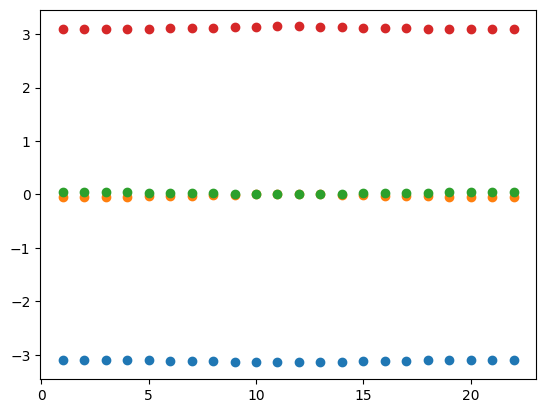

PyObject <matplotlib.collections.PathCollection object at 0x7f7987560c70>

In [44]:
wilson_evals = readdlm("wilson_loops/output/dim2-sg10-27163-res192-te-phases.out", ',')[:, 12:15]
scatter(1:22, wilson_evals[:, 1])
scatter(1:22, wilson_evals[:, 2])
scatter(1:22, wilson_evals[:, 3])
scatter(1:22, wilson_evals[:, 4])

In [60]:
#cumsummariesv = loaded_data["cumsummariesv"]
dispersionsv = loaded_data["dispersionsv"];

In [66]:
cumfragile_idxs = Int[]
for (idx, cumsummaries) in enumerate(cumsummariesv)
    for cumsummary in cumsummaries 
        if cumsummary.topology == FRAGILE
            push!(cumfragile_idxs, idx)
        end
    end
end

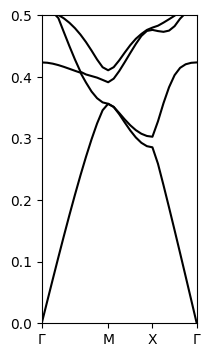

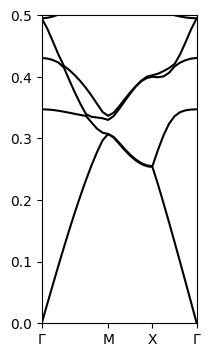

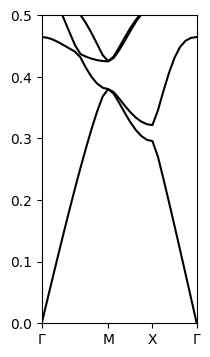

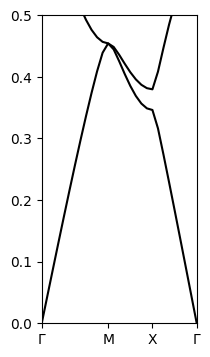

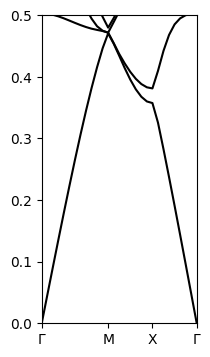

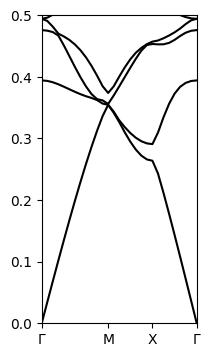

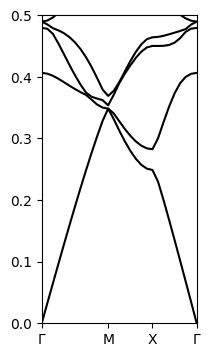

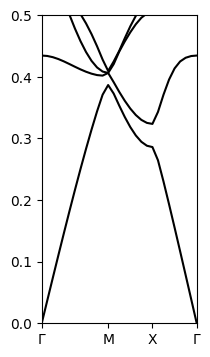

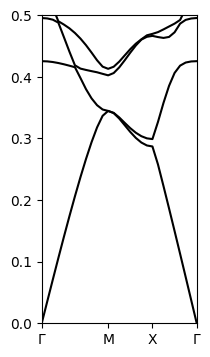

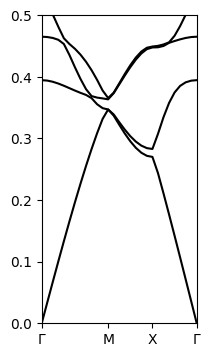

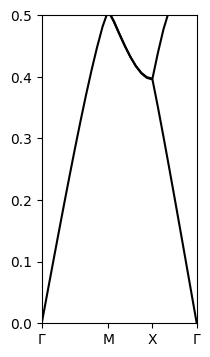

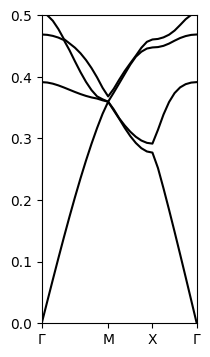

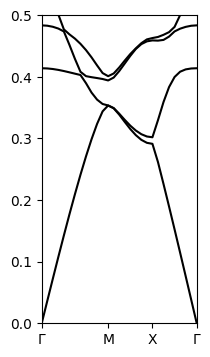

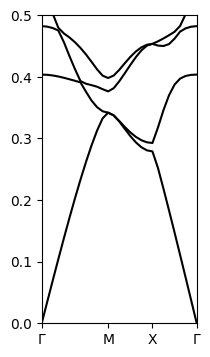

In [67]:
for idx in cumfragile_idxs
    figure(figsize=(2,4))
    plot(dispersionsv[idx][:, 1:5], color="black")
    xticks([0, 12, 20, 28], ["Γ", "M", "X", "Γ"])
    xlim(0, 28)
    ylim(0, 0.5)
end